# Forward Start Options Pricing with the Heston Model Using the COS Method

This notebook explains the code for pricing forward start options using the COS method under the Heston model. Each function is broken down with the mathematical formulas (in LaTeX) and intuitive explanations.

---

## 1. `CallPutOptionPriceCOSMthd_FrwdStart(cf, CP, r, T1, T2, K, N, L)`

### What It Does
This function computes the price of a forward start option using the COS method. A forward start option starts at time \( T_1 \) and expires at \( T_2 \). The method relies on the characteristic function \( \phi(u) \) of the underlying process.

### Mathematical Explanation

1. **Time to Maturity:**

   We define:
   $$
   \tau = T_2 - T_1.
   $$

2. **Adjustment of Strike:**

   The strike \( K \) is shifted (here by adding 1.0) as per model requirements.

3. **Log-Moneyness:**

   Since the forward start option is set with a forward value of 1, we have:
   $$
   x_0 = \ln\left(\frac{1}{K}\right).
   $$

4. **Truncation Domain:**

   The integration interval is defined by:
   $$
   a = -L\sqrt{\tau}, \quad b = L\sqrt{\tau}.
   $$

5. **COS Method Formula:**

   The option price is computed as:
   $$
   V \approx e^{-r T_2} \, K \sum_{k=0}^{N-1} \operatorname{Re}\left\{ e^{i\, u_k (x_0 - a)}\, \phi(u_k)\, H_k \right\},
   $$
   where
   $$
   u_k = \frac{k\pi}{b-a}.
   $$

### Nitish Sir Hinglish Explanation
"Yeh function forward start option ka price COS method se calculate karta hai. Forward start matlab option future me start hoga, isliye \( T_1 \) aur \( T_2 \) diye hain. Integration ke liye domain \( [-L\sqrt{\tau}, L\sqrt{\tau}] \) set kiya hai, aur Fourier cosine serie\(\l s1 au vethod aur Heston characteristic function use karke option price aur implied volatility calculate karta hai. Alag maturity pairs ke liye plot bana ke market behavior dikhata hai."

---

*Happy studying and best of luck with your quant journey!*
 and accuracy in option pricing, especially for models with known characteristic functions.

- **Model Calibration:**  
  Knowing how to compute and explain these formulas is crucial for quant interviews and real-world model calibration.

*Happy coding and best of luck with your quant journey!*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import enum 
import scipy.optimize as optimize

import seaborn as sns

# Set seaborn style for better aesthetics
sns.set_style("whitegrid")
# set i= imaginary number
i   = 1j

# This class defines puts and calls
class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0

def CallPutOptionPriceCOSMthd_FrwdStart(cf,CP,r,T1,T2,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    tau = T2 - T1
    # reshape K to a column vector
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Adjust strike
    K = K + 1.0
    
    #assigning i=sqrt(-1)
    i = 1j
    x0 = np.log(1.0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = np.exp(-r * T2) * K * np.real(mat.dot(temp))     
    return value


## 2. `CallPutCoefficients(CP, a, b, k)`

### What It Does
This function calculates the Fourier cosine coefficients \( H_k \) needed to expand the payoff function in the COS method.

### Mathematical Explanation

- **For a Call Option:**
  $$
  H_k = \frac{2}{b-a} \left(\chi_k - \psi_k\right).
  $$
- **For a Put Option:**
  $$
  H_k = \frac{2}{b-a} \left(\psi_k - \chi_k\right).
  $$

Here, \( \chi_k \) and \( \psi_k \) are computed in the `Chi_Psi` function.

### Nitish Sir Hinglish Explanation
"Yeh function option ke payoff ko Fourier series me express karne ke liye coefficients \( H_k \) nikalta hai. Call ke liye \( \chi - \psi \) aur put ke liye \( \psi - \chi \) use karte hain."

---

In [2]:
# Determine coefficients for Put and Call Prices 
def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    


## 3. `Chi_Psi(a, b, c, d, k)`

### What It Does
This function computes the two key integrals, \( \chi_k \) and \( \psi_k \), which form the basis of the Fourier cosine expansion of the payoff function.

### Mathematical Explanation

1. **For \(\psi_k\):**
   - For \( k = 0 \):
     $$
     \psi_0 = d - c.
     $$
   - For \( k > 0 \):
     $$
     \psi_k = \frac{b-a}{k\pi} \left[\sin\left(\frac{k\pi (d-a)}{b-a}\right) - \sin\left(\frac{k\pi (c-a)}{b-a}\right)\right].
     $$

2. **For \(\chi_k\):**
   Start with:
   $$
   \chi_k = \frac{1}{1+\left(\frac{k\pi}{b-a}\right)^2},
   $$
   then modify with:
   $$
   \chi_k = \chi_k \times \left[\cos\left(\frac{k\pi (d-a)}{b-a}\right)e^d - \cos\left(\frac{k\pi (c-a)}{b-a}\right)e^c + \frac{k\pi}{b-a}\left(\sin\left(\frac{k\pi (d-a)}{b-a}\right) - \sin\left(\frac{k\pi (c-a)}{b-a}\right)e^c\right)\right].
   $$

### Nitish Sir Hinglish Explanation
"Yeh function do parts banata hai—\( \chi \) aur \( \psi \)—jo integration ke through payoff ko series me likhne me madad karte hain. Yeh coefficients se hi option ka price nikalna asaan ho jata hai."

In [3]:
def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value

---

## 4. `BS_Call_Option_Price_FrwdStart(K, sigma, T1, T2, r)`

### What It Does
This function calculates the forward start option price using the Black–Scholes formula adapted for forward start options.

### Mathematical Explanation

1. **Adjust Strike:**
   $$
   K \rightarrow K + 1.0.
   $$

2. **Time to Maturity:**
   $$
   \tau = T_2 - T_1.
   $$

3. **Compute \( d_1 \) and \( d_2 \):**
   $$
   d_1 = \frac{\ln\left(\frac{1}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right)\tau}{\sigma\sqrt{\tau}}, \quad
   d_2 = d_1 - \sigma\sqrt{\tau}.
   $$

4. **Option Price:**
   $$
   V = e^{-rT_1}\Phi(d_1) - K \, e^{-rT_2}\Phi(d_2),
   $$
   where \( \Phi(\cdot) \) is the cumulative distribution function of the standard normal distribution.

### Nitish Sir Hinglish Explanation
"Black–Scholes formula forward start option ke liye thoda modify ki gayi hai. \( d_1 \) aur \( d_2 \) se probability nikal ke price compute karte hain, discount factor \( e^{-rT_1} \) aur \( e^{-rT_2} \) lagate hain."

---

In [4]:
# Forward start Black-Scholes option price
def BS_Call_Option_Price_FrwdStart(K,sigma,T1,T2,r):
    if K is list:
        K = np.array(K).reshape([len(K),1])
    K = K + 1.0 
    tau = T2 - T1
    d1    = (np.log(1.0 / K) + (r + 0.5 * np.power(sigma,2.0))* tau) / (sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    value = np.exp(-r*T1) * stats.norm.cdf(d1) - stats.norm.cdf(d2) * K * np.exp(-r * T2)
    return value

## 5. `ImpliedVolatility_FrwdStart(marketPrice, K, T1, T2, r)`

### What It Does
This function computes the implied volatility for a forward start option by matching the Black–Scholes price to the observed (or computed) market price.

### Mathematical Explanation

The goal is to solve for \( \sigma \) such that:
$$
\text{BS\_Call\_Option\_Price\_FrwdStart}(K,\sigma,T_1,T_2,r) = \text{marketPrice}.
$$

- **Initial Guess:**  
  A grid search over \(\sigma\) is performed (typically from 0 to 2) to obtain an initial guess.
- **Refinement:**  
  Newton's method is used to solve the equation with high precision:
  $$
  f(\sigma) = \text{BS\_Price}(\sigma) - \text{marketPrice} = 0.
  $$

### Nitish Sir Hinglish Explanation
"Yeh function market price aur Black–Scholes price ko match karke implied volatility nikalta hai. Pehle ek sigma grid se guess leta hai, fir Newton method se exact sigma find karta hai."

---

In [5]:
def ImpliedVolatility_FrwdStart(marketPrice,K,T1,T2,r):
    # To determine initial volatility we interpolate define a grid for sigma
    # and interpolate on the inverse
    sigmaGrid = np.linspace(0,2,200)
    optPriceGrid = BS_Call_Option_Price_FrwdStart(K,sigmaGrid,T1,T2,r)
    sigmaInitial = np.interp(marketPrice,optPriceGrid,sigmaGrid)
    print("Initial volatility = {0}".format(sigmaInitial))
    
    # Use determined input for the local-search (final tuning)
    func = lambda sigma: np.power(BS_Call_Option_Price_FrwdStart(K,sigma,T1,T2,r) - marketPrice, 1.0)
    impliedVol = optimize.newton(func, sigmaInitial, tol=1e-15)
    print("Final volatility = {0}".format(impliedVol))
    return impliedVol

## 6. `ChFHestonModelForwardStart(r, T1, T2, kappa, gamma, vbar, v0, rho)`

### What It Does
This function constructs the characteristic function \( \phi(u) \) for the forward start option under the Heston stochastic volatility model.

### Mathematical Explanation

1. **Time to Maturity:**
   $$
   \tau = T_2 - T_1.
   $$

2. **Define \( D_1(u) \):**
   $$
   D_1(u) = \sqrt{\left(\kappa - \gamma\rho\, i\, u\right)^2 + \gamma^2 \left(u^2 + i\,u\right)}.
   $$

3. **Define \( g(u) \):**
   $$
   g(u) = \frac{\kappa - \gamma\rho\, i\, u - D_1(u)}{\kappa - \gamma\rho\, i\, u + D_1(u)}.
   $$

4. **Compute \( C(u) \):**
   $$
   C(u) = \frac{1 - e^{-D_1(u)\tau}}{\gamma^2 \left(1 - g(u) e^{-D_1(u)\tau}\right)} \left(\kappa - \gamma\rho\, i\, u - D_1(u)\right).
   $$

5. **Define \( A(u) \):**
   $$
   A(u) = r\, i\, u\, \tau + \frac{\kappa v_{\text{bar}} \tau}{\gamma^2}\left(\kappa - \gamma\rho\, i\, u - D_1(u)\right) - \frac{2\kappa v_{\text{bar}}}{\gamma^2}\ln\left(\frac{1 - g(u) e^{-D_1(u)\tau}}{1 - g(u)}\right).
   $$

6. **Forward-Start Adjustments:**

   Define auxiliary functions:
   $$
   c_{\text{bar}}(t_1,t_2) = \frac{\gamma^2}{4\kappa} \left(1 - e^{-\kappa (t_2-t_1)}\right),
   $$
   $$
   \kappa_{\text{bar}}(t_1,t_2) = \frac{4\kappa v_0 \, e^{-\kappa(t_2-t_1)}}{\gamma^2\left(1 - e^{-\kappa(t_2-t_1)}\right)}.
   $$
   
   Then define:
   $$
   \text{term1}(u) = A(u) + \frac{C(u)\, c_{\text{bar}}(0, T_1)\, \kappa_{\text{bar}}(0, T_1)}{1 - 2 C(u)\, c_{\text{bar}}(0, T_1)},
   $$
   $$
   \delta = \frac{4\kappa v_{\text{bar}}}{\gamma^2},
   $$
   $$
   \text{term2}(u) = \left[\frac{1}{1 - 2 C(u)\, c_{\text{bar}}(0, T_1)}\right]^{0.5\, \delta}.
   $$

7. **Characteristic Function:**
   $$
   \phi(u) = \exp\left(\text{term1}(u)\right) \times \text{term2}(u).
   $$

### Nitish Sir Hinglish Explanation
"Yeh function Heston model ke under forward start option ka characteristic function banata hai. Pehle \( D_1(u) \), \( g(u) \), \( C(u) \) aur \( A(u) \) se basic volatility dynamics set karte hain, phir forward start ke liye extra adjustments (\( c_{\text{bar}} \) aur \( \kappa_{\text{bar}} \)) add karte hain. Bas, phir exponential form me characteristic function nikal jaata hai."

---

In [6]:
def ChFHestonModelForwardStart(r,T1,T2,kappa,gamma,vbar,v0,rho):
    i = 1j
    tau = T2 - T1
    D1 = lambda u: np.sqrt(np.power(kappa-gamma*rho*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = lambda u: (kappa-gamma*rho*i*u-D1(u))/(kappa-gamma*rho*i*u+D1(u))
    C  = lambda u: (1.0-np.exp(-D1(u)*tau))/(gamma*gamma*(1.0-g(u)*np.exp(-D1(u)*tau)))\
        *(kappa-gamma*rho*i*u-D1(u))
    # Note that we exclude the term -r*tau, as the discounting is performed in the COS method
    A  = lambda u: r*i*u*tau + kappa*vbar*tau/gamma/gamma *(kappa-gamma*rho*i*u-D1(u))\
        - 2*kappa*vbar/gamma/gamma*np.log((1.0-g(u)*np.exp(-D1(u)*tau))/(1.0-g(u)))
    c_bar = lambda t1,t2: gamma*gamma/(4.0*kappa) * (1.0 - np.exp(-kappa*(t2-t1)))
    delta = 4.0*kappa*vbar/gamma/gamma
    kappa_bar = lambda t1, t2: 4.0*kappa*v0*np.exp(-kappa*(t2-t1))/(gamma*gamma*(1.0-np.exp(-kappa*(t2-t1))))
    term1 = lambda u: A(u) + C(u)*c_bar(0.0,T1)*kappa_bar(0.0,T1)/(1.0-2.0*C(u)*c_bar(0.0,T1))
    term2 = lambda u: np.power(1.0/(1.0-2.0*C(u)*c_bar(0.0,T1)),0.5*delta)
    cf = lambda u: np.exp(term1(u)) * term2(u)
    return cf

function to plot implied volatility for a Heston forward-start option.

In [7]:
def plot_implied_volatility_heston(K, TMat, title, color_palette, r, kappa, gamma, vbar, v0, rho, CP, N, L):
    """
    F
    
    Parameters:
    - K: Strike prices
    - TMat: List of (T1, T2) pairs for forward-start options
    - title: Title of the plot (str)
    - color_palette: Seaborn color palette (str)
    - Other model parameters required for computation
    """
    plt.figure(figsize=(8, 5))
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Strike, K", fontsize=12)
    plt.ylabel("Implied Volatility (%)", fontsize=12)
    plt.grid()

    legend = []
    colors = sns.color_palette(color_palette, len(TMat))

    for i, (T1, T2) in enumerate(TMat):
        cf = ChFHestonModelForwardStart(r, T1, T2, kappa, gamma, vbar, v0, rho)
        valCOS = CallPutOptionPriceCOSMthd_FrwdStart(cf, CP, r, T1, T2, K, N, L)

        # Compute implied volatilities
        IV = np.array([ImpliedVolatility_FrwdStart(valCOS[idx], K[idx], T1, T2, r) for idx in range(len(K))])

        # Plot with unique color
        plt.plot(K, IV * 100.0, linestyle='--', marker='o', markersize=4, color=colors[i], label=f"T1={T1}, T2={T2}")

    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

## 7. `mainCalculation()`

### What It Does
This is the driver function that:

1. Sets up different maturity pairs (e.g., \( T_1 \) and \( T_2 \)) and a range of strikes \( K \).
2. Uses the Heston model characteristic function for forward start options.
3. Prices options using the COS method.
4. Computes the implied volatilities for each strike.
5. Plots the implied volatility smiles for different maturity pairs.

### Nitish Sir Hinglish Explanation
"Main calculation function sab parameters set karta hai (maturity pairs, strikes, model parameters), phir COS method aur Heston characteristic function use karke option price aur implied volatility calculate karta hai. Alag maturity pairs ke liye plot bana ke market behavior dikhata hai."

---

*Happy studying and best of luck with your quant journey!*

In [8]:
def mainCalculation():
    CP  = OptionType.CALL
    r   = 0.00
    
    TMat1=[[1.0,3.0],[2.0,4.0],[3.0, 5.0],[4.0, 6.0]]
    TMat2=[[1.0,2.0],[1.0,3.0],[1.0, 4.0],[1.0, 5.0]]
    T1=1.0  
    T2=2.0
    K = np.linspace(-0.4,4.0,50)
   
    K = np.array(K).reshape([len(K),1])
    
    N = 500
    L = 10
        
    # Heston model parameters
    kappa = 0.6
    gamma = 0.2
    vbar  = 0.1
    rho   = -0.5
    v0    = 0.05   
    
    # Call the plotting function for both cases
    plot_implied_volatility_heston(K, TMat1, "Heston Model: Forward-Start IV (Short-Term)", "coolwarm", r, kappa, gamma, vbar, v0, rho, CP, N, L)
    plot_implied_volatility_heston(K, TMat2, "Heston Model: Forward-Start IV (Long-Term)", "viridis", r, kappa, gamma, vbar, v0, rho, CP, N, L)
    
    cf = ChFHestonModelForwardStart(r, T1, T2, kappa, gamma, vbar, v0, rho)
    
    # Calculate the forward start option price using the COS method:
    option_price = CallPutOptionPriceCOSMthd_FrwdStart(cf, CP, r, T1, T2, K, N, L)
    
    # Print the resulting option price:
    print("Forward Start Option Price (COS Method) for T1 = {} and T2 = {}:".format(T1, T2))
    print(option_price)
    
    # Plot the option prices vs. strikes:
    plt.figure(figsize=(10, 6))
    plt.plot(K, option_price, 'b-', linewidth=2, label="Option Price")
    plt.xlabel("Strike (K)", fontsize=14)
    plt.ylabel("Forward Start Option Price", fontsize=14)
    plt.title("Forward Start Option Price vs. Strike", fontsize=16)
    plt.grid(True)
    plt.legend()
    plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_19132\39600098.py:7: RuntimeWarning: divide by zero encountered in divide
  d1    = (np.log(1.0 / K) + (r + 0.5 * np.power(sigma,2.0))* tau) / (sigma * np.sqrt(tau))


Initial volatility = [0.31192467]
Final volatility = [0.3119319]
Initial volatility = [0.30208092]
Final volatility = [0.30208715]
Initial volatility = [0.29359471]
Final volatility = [0.29360364]
Initial volatility = [0.28631279]
Final volatility = [0.28631625]
Initial volatility = [0.28011355]
Final volatility = [0.28011299]
Initial volatility = [0.27490873]
Final volatility = [0.27490777]
Initial volatility = [0.27062136]
Final volatility = [0.27062241]
Initial volatility = [0.26716387]
Final volatility = [0.26717596]
Initial volatility = [0.26445985]
Final volatility = [0.2644806]
Initial volatility = [0.26242763]
Final volatility = [0.26244284]
Initial volatility = [0.26096025]
Final volatility = [0.26096793]
Initial volatility = [0.25992889]
Final volatility = [0.25996498]
Initial volatility = [0.25928935]
Final volatility = [0.25935099]
Initial volatility = [0.2589699]
Final volatility = [0.2590532]
Initial volatility = [0.25890957]
Final volatility = [0.25900971]
Initial volati

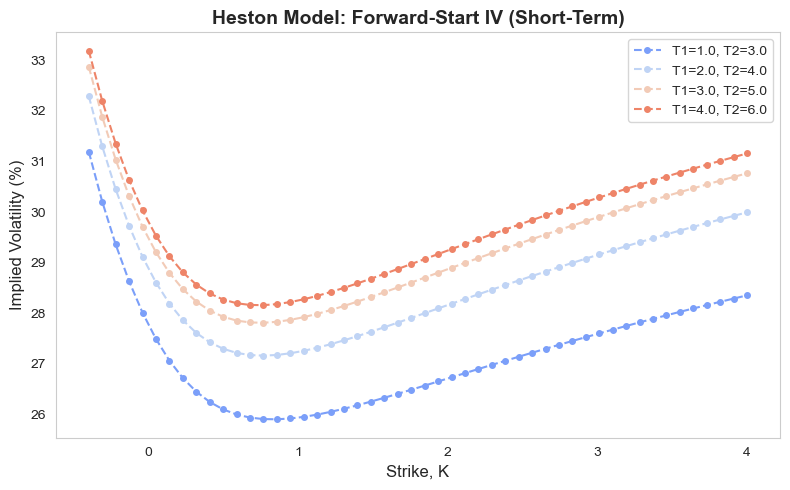

Initial volatility = [0.31869603]
Final volatility = [0.31877913]
Initial volatility = [0.30487934]
Final volatility = [0.30493295]
Initial volatility = [0.29282261]
Final volatility = [0.29283653]
Initial volatility = [0.28246129]
Final volatility = [0.28246497]
Initial volatility = [0.27391593]
Final volatility = [0.27391606]
Initial volatility = [0.26733169]
Final volatility = [0.26733235]
Initial volatility = [0.26277223]
Final volatility = [0.26277753]
Initial volatility = [0.26010943]
Final volatility = [0.26012216]
Initial volatility = [0.25900614]
Final volatility = [0.25904528]
Initial volatility = [0.25909159]
Final volatility = [0.25915002]
Initial volatility = [0.26002379]
Final volatility = [0.26007594]
Initial volatility = [0.26153172]
Final volatility = [0.26154487]
Initial volatility = [0.26324373]
Final volatility = [0.26335909]
Initial volatility = [0.26517565]
Final volatility = [0.26538334]
Initial volatility = [0.26728519]
Final volatility = [0.26752664]
Initial vo

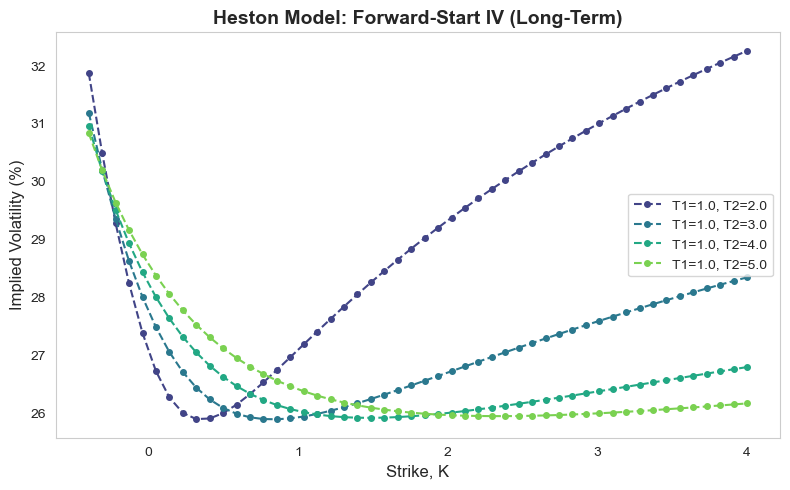

Forward Start Option Price (COS Method) for T1 = 1.0 and T2 = 2.0:
[[4.05652831e-01]
 [3.23793092e-01]
 [2.48646762e-01]
 [1.82806531e-01]
 [1.28345691e-01]
 [8.61750740e-02]
 [5.56951299e-02]
 [3.50143606e-02]
 [2.16603448e-02]
 [1.33150430e-02]
 [8.19203974e-03]
 [5.06856304e-03]
 [3.16313687e-03]
 [1.99461527e-03]
 [1.27211385e-03]
 [8.20933565e-04]
 [5.36101787e-04]
 [3.54234968e-04]
 [2.36771256e-04]
 [1.60033995e-04]
 [1.09338469e-04]
 [7.54801024e-05]
 [5.26269697e-05]
 [3.70441189e-05]
 [2.63140246e-05]
 [1.88556237e-05]
 [1.36242826e-05]
 [9.92313152e-06]
 [7.28274311e-06]
 [5.38403102e-06]
 [4.00824741e-06]
 [3.00404630e-06]
 [2.26587616e-06]
 [1.71963079e-06]
 [1.31279439e-06]
 [1.00787744e-06]
 [7.78001085e-07]
 [6.03716577e-07]
 [4.70805580e-07]
 [3.68934181e-07]
 [2.90473609e-07]
 [2.29715745e-07]
 [1.82449679e-07]
 [1.45493508e-07]
 [1.16531916e-07]
 [9.36871199e-08]
 [7.55756274e-08]
 [6.11933853e-08]
 [4.97447948e-08]
 [4.05736054e-08]]


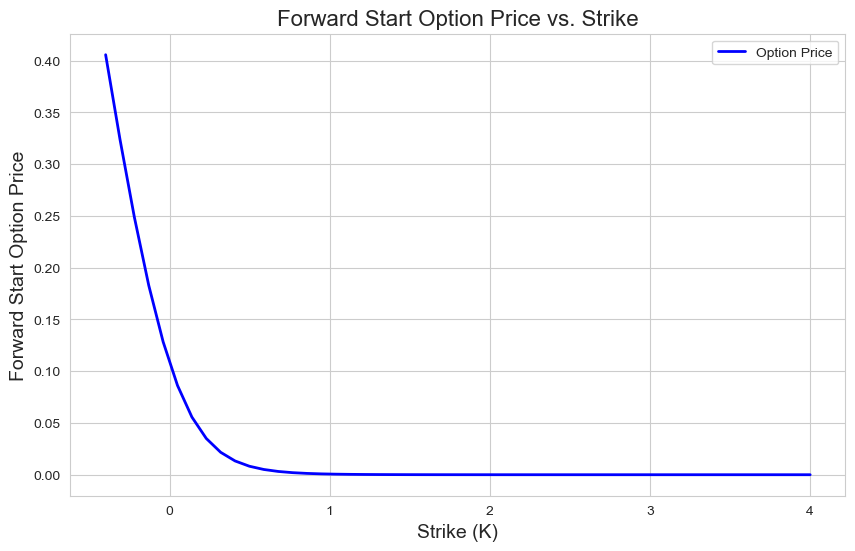

In [9]:
mainCalculation()

In [ ]:
"""
    plt.figure(1)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    legend = []
    for T_pair in TMat1:
       T1= T_pair[0]
       T2= T_pair[1]
       cf = ChFHestonModelForwardStart(r,T1,T2,kappa,gamma,vbar,v0,rho)
       # Forward-start option from the COS method
       valCOS = CallPutOptionPriceCOSMthd_FrwdStart(cf,CP,r,T1,T2,K,N,L)
       # Implied volatilities
       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility_FrwdStart(valCOS[idx],K[idx],T1,T2,r)
       plt.plot(K,IV*100.0)
       legend.append('T1={0} & T2={1}'.format(T1,T2))
    plt.legend(legend)
    
    plt.figure(2)
    plt.grid()
    plt.xlabel('strike, K')
    plt.ylabel('implied volatility')
    legend = []
    for T_pair in TMat2:
       T1= T_pair[0]
       T2= T_pair[1]
       cf = ChFHestonModelForwardStart(r,T1,T2,kappa,gamma,vbar,v0,rho)
       
       # Forward-start option from the COS method
       valCOS = CallPutOptionPriceCOSMthd_FrwdStart(cf,CP,r,T1,T2,K,N,L)
    
       # Implied volatilities
       IV =np.zeros([len(K),1])
       for idx in range(0,len(K)):
           IV[idx] = ImpliedVolatility_FrwdStart(valCOS[idx],K[idx],T1,T2,r)
       plt.plot(K,IV*100.0)
       legend.append('T1={0} & T2={1}'.format(T1,T2))
       
    plt.legend(legend)"""
